In [34]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten,Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import cv2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

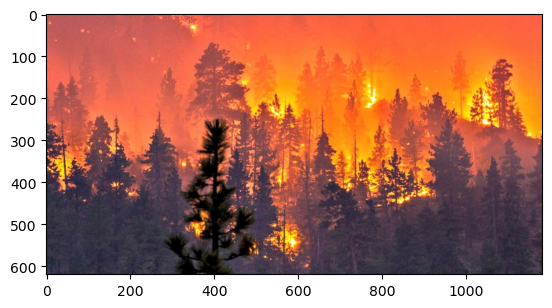

In [7]:
fi_filenames=os.listdir("fire_dataset/fire_images")
fi_ch=random.choice(fi_filenames)
fi_image=load_img("fire_dataset/fire_images/"+ fi_ch)
plt.imshow(fi_image)

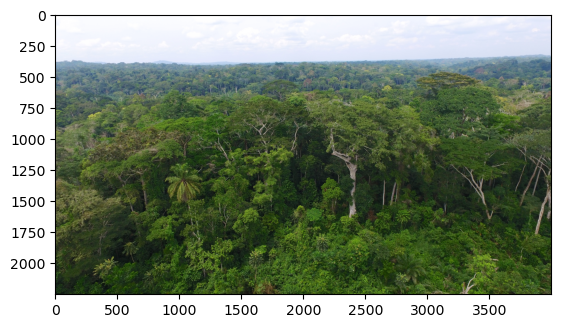

In [6]:
nf_filenames=os.listdir("fire_dataset/non_fire_images")
nf_ch=random.choice(nf_filenames)
nf_image=load_img("fire_dataset/non_fire_images/"+ nf_ch)
plt.imshow(nf_image)

In [17]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE=16

# Training Data Generator

In [18]:
train_datagen=ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=0.1
)

In [19]:
train_generator=train_datagen.flow_from_directory("fire_dataset",
                                                 target_size=(128,128),
                                                 class_mode="binary",
                                                 batch_size=BATCH_SIZE,color_mode='rgb',subset="training")

validation_generator=train_datagen.flow_from_directory("fire_dataset",
                                                 target_size=(128,128),
                                                 class_mode="binary",
                                                 batch_size=BATCH_SIZE,color_mode='rgb',subset="validation")

Found 900 images belonging to 2 classes.
Found 99 images belonging to 2 classes.


In [29]:
model=Sequential()
model.add(Conv2D(32,(3,3), activation="relu", input_shape= (IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Conv2D(64,(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_12 (Ba  (None, 126, 126, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 63, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_13 (Ba  (None, 61, 61, 64)       

In [30]:
earlystop = EarlyStopping(patience=10)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [48]:
model.fit(
    train_generator, 
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples//BATCH_SIZE,
    steps_per_epoch=train_generator.samples//BATCH_SIZE,
    callbacks=callbacks)

Epoch 1/50
56/56 [==============================] - 40s 705ms/step - loss: 0.0000e+00 - accuracy: 0.9412 - val_loss: 0.0000e+00 - val_accuracy: 0.8646 - lr: 1.2500e-04
Epoch 2/50
56/56 [==============================] - 39s 704ms/step - loss: 0.0000e+00 - accuracy: 0.9559 - val_loss: 0.0000e+00 - val_accuracy: 0.9062 - lr: 1.2500e-04
Epoch 3/50
56/56 [==============================] - 38s 672ms/step - loss: 0.0000e+00 - accuracy: 0.9412 - val_loss: 0.0000e+00 - val_accuracy: 0.9271 - lr: 1.2500e-04
Epoch 4/50
56/56 [==============================] - 38s 681ms/step - loss: 0.0000e+00 - accuracy: 0.9491 - val_loss: 0.0000e+00 - val_accuracy: 0.9479 - lr: 1.2500e-04
Epoch 5/50
56/56 [==============================] - 37s 660ms/step - loss: 0.0000e+00 - accuracy: 0.9548 - val_loss: 0.0000e+00 - val_accuracy: 0.9271 - lr: 1.2500e-04
Epoch 6/50
56/56 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.9491
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.2500002

# Model Testing

In [51]:
for i in range(10):
    all_test_images = os.listdir("fire_dataset/fire_images")
    random_image = random.choice(all_test_images)
    img = cv2.imread(f'fire_dataset/fire_images/{random_image}')
    img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH))
    
    org = img.copy()
    img = img.reshape(1,128,128,3)
    
    pred = model.predict(img)
    print(int(pred[0][0]))
    print(['Fire','Non-Fire'][int(pred[0][0])])
    cv2.imshow('Live predictions',org)
    cv2.waitKey(0)
cv2.destroyAllWindows()

1/1 [==============================] - 0s 39ms/step
1
Non-Fire
1/1 [==============================] - 0s 42ms/step
0
Fire
1/1 [==============================] - 0s 39ms/step
1
Non-Fire
1/1 [==============================] - 0s 45ms/step
0
Fire
1/1 [==============================] - 0s 41ms/step
1
Non-Fire
1/1 [==============================] - 0s 40ms/step
1
Non-Fire
1/1 [==============================] - 0s 40ms/step
1
Non-Fire
1/1 [==============================] - 0s 41ms/step
1
Non-Fire
1/1 [==============================] - 0s 43ms/step
1
Non-Fire
1/1 [==============================] - 0s 42ms/step
1
Non-Fire
